In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import cartopy

Caricamento dei file pickle

In [2]:
# Caricamento di models e models_atmos
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
#Caricamento dei file pickle di modelli_tos
with open('modelli_tos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0_pca = pickle.load(f)
    list_cluster1_pca = pickle.load(f)
    list_cluster2_pca = pickle.load(f)
    list_cluster3_pca = pickle.load(f)
    list_cluster4_pca = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    cluster_0_pdf = pickle.load(f)
    cluster_1_pdf = pickle.load(f)
    cluster_2_pdf = pickle.load(f)
    cluster_3_pdf = pickle.load(f)
    cluster_4_pdf = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    cluster_0_mean_pdf = pickle.load(f)
    cluster_1_mean_pdf = pickle.load(f)
    cluster_2_mean_pdf = pickle.load(f)
    cluster_3_mean_pdf = pickle.load(f)
    cluster_4_mean_pdf = pickle.load(f)

In [3]:
list_cluster0 = list_cluster0_pca
list_cluster1 = list_cluster1_pca
list_cluster2 = list_cluster2_pca
list_cluster3 = list_cluster3_pca
list_cluster4 = list_cluster4_pca

In [4]:
#Bias modelli
for name in models:
    #Seleziono il box Nord Atlantico
    na_box = models[name]['North Atlantic box']
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli, per un anno --> da aggiungere anni!
        model_na_seas_mean = compute_mean_resample_mar(na_box["tos"],"1982","2014",i)
        if (i+1) == 4 : #DJF
            models[name]['tos North Atlantic seasonal mean DJF'] = model_na_seas_mean

Posizione della corrente del Golfo

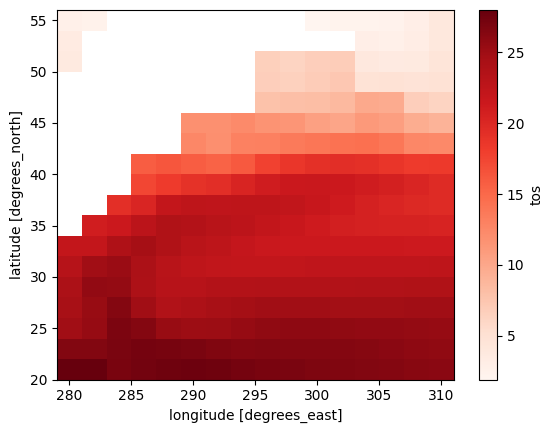

In [5]:
models['ACCESS-CM2']['tos North Atlantic seasonal mean DJF'].sel(lon=slice(280,310), lat=slice(20,55)).plot(cmap = 'Reds')

In [6]:
#seleziono un sottobox in cui vado a cercare la corrente del Golfo
for name in models.keys():
    models[name]['GS box seas mean DJF'] = models[name]['tos North Atlantic seasonal mean DJF'].sel(lon=slice(282,310), lat=slice(29,55)) #box Gulf Stream, rimeetti lat=20

Media di seasonal mean DJF per ogni cluster + gradiente della media + punti dove il gradiente è massimo

In [31]:
n_clusters = 5 #number clusters
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3,list_cluster4]
mean_cluster = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)))# (5,len(lat),len(lon)) 
for i in range(len(list_clusters)): #ciclo su tutte le 5 liste, cioè su tutti e 5 i cluster
    sum_bias = 0
    for j in range(len(list_clusters[i])): #ciclo sui singoli modelli della lista i-esima
        model_name = list_clusters[i][j] #modello j-esimo della lista i-esima
        sum_bias = sum_bias + models[model_name]['GS box seas mean DJF']
    mean_cluster[i,:,:] = (sum_bias / len(list_clusters[i])) #media

In [32]:
#Ricerca del valore massimo sulla latitudine, a longitudine fissata
array_max = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon))) #di dimesnioni 5xlatxlon
gradient = np.zeros((n_clusters,len(models[list_cluster0[0]]['GS box seas mean DJF'].lat),len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)))
for n in range(n_clusters): #ciclo sui 5 cluster
    max_value = -999 #inizializzo il valore massimo
    for j in range(len(models[list_cluster0[0]]['GS box seas mean DJF'].lon)): #ciclo sulle longitudini
        gradient[n,:,j] = np.gradient(mean_cluster[n,:,j]) #derivata lungo l'array (n,tutte le lat,lon=j), che ha valori fissati di cluster scelto e longitudine
        index_max_value = np.nanargmax(abs(gradient[n,:,j])) #determino l'indice del valore massimo, non considero i nan come possibili valori massimi
        #Determino la matrice array_max formata da 0 e 1, dove 1 rappresenta la posizione del valore massimo
        for i in range(len(models[list_cluster0[0]]['GS box seas mean DJF'].lat)): #ciclo sulle latitudini, a longitudine fissa
            if i == index_max_value: #se valore massimo metto 1 nella matrice array_max
                array_max[n,i,j] = 1
            else:
                array_max[n,i,j] = 0

Plot per ogni cluster di media cluster e gradiente cluster, con sopra punti in cui il gradiente è massimo

In [39]:
lat = models[list_cluster0[0]]['GS box seas mean DJF'].lat.values
lon = models[list_cluster0[0]]['GS box seas mean DJF'].lon.values

Text(0.5, 0.92, 'SST e gradiente SST per ogni cluster')

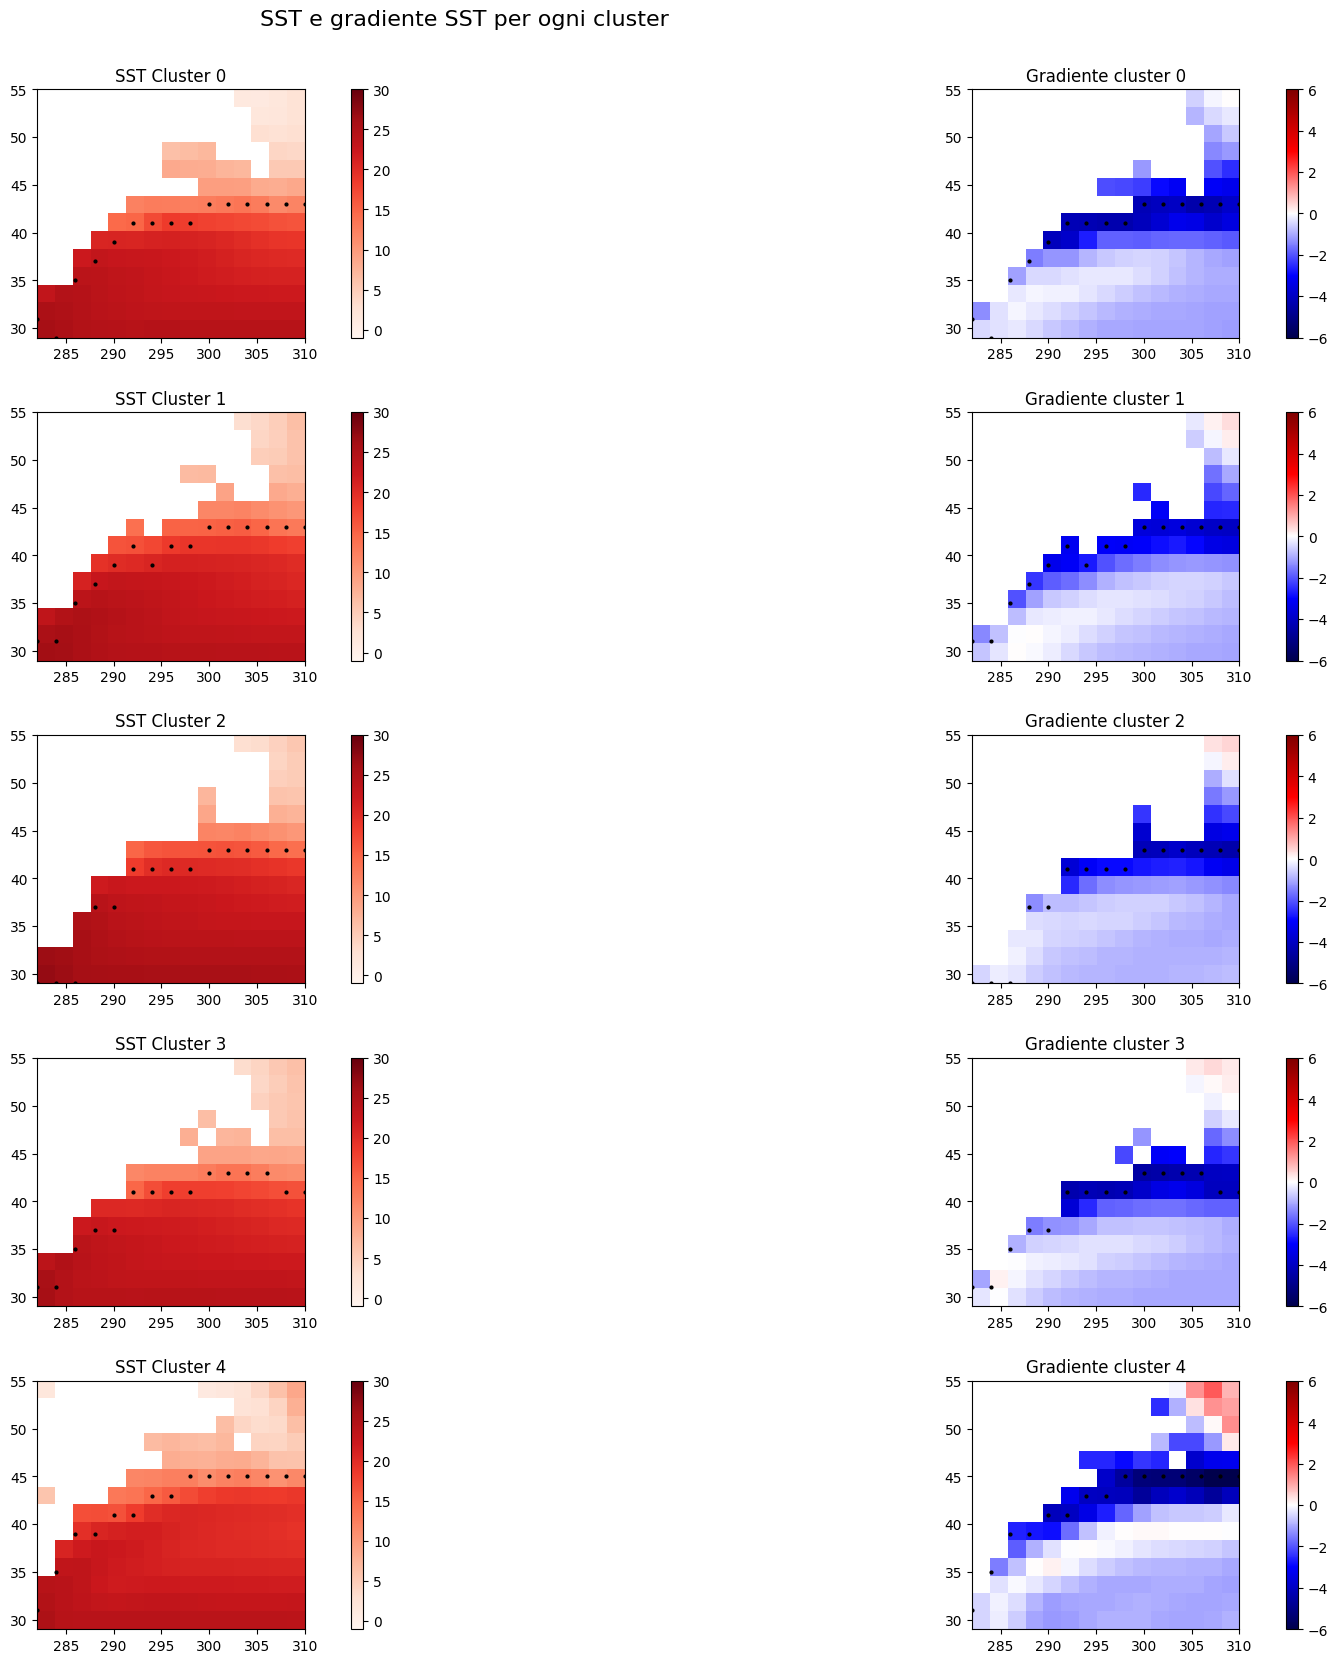

In [50]:
index = 0 #inizializzo l'indice che individua ogni cluster
fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(24,20))
fig.subplots_adjust(hspace=0.3, wspace=0.01)  # Aggiungo spazi verticali e orizzontali tra le subplots
for i in range(5): #Ciclo sulle righe
    j = 0 #inziializzo indice per le colonne
    coords = np.where(array_max[index,:,:] == 1) #array di valori di longitudini e latitudini in cui array_max = 1 (cioè indica la posizione in cui c'è il max))
    #Plot della prima colonna, cioè di SST
    # Plot dei punti solo dove array_max è uguale a 1
    punti = ax[i,j].plot(lon[coords[1]], lat[coords[0]], marker='o', color='black', markersize=2, linestyle='None')
    plot_mod = ax[i,j].imshow(mean_cluster[index,::-1,:],extent=[lon.min(), lon.max(), lat.min(), lat.max()],vmin=-1, vmax=30,cmap='Reds')
    ax[i,j].set_title(f'SST Cluster {index}')
    fig.colorbar(plot_mod,ax=ax[i,j])
    #Plot della seconda colonna, cioè del gradiente di SST
    punti = ax[i,j+1].plot(lon[coords[1]], lat[coords[0]], marker='o', color='black', markersize=2, linestyle='None')
    plot_mod = ax[i,j+1].imshow(gradient[index,::-1,:],extent=[lon.min(), lon.max(), lat.min(), lat.max()],vmin=-6, vmax=6,cmap='seismic')
    ax[i,j+1].set_title(f'Gradiente cluster {index}')
    fig.colorbar(plot_mod,ax=ax[i,j+1])

    index = index + 1 #Aggiorno index

fig.suptitle('SST e gradiente SST per ogni cluster', fontsize=16, y=0.92)
        

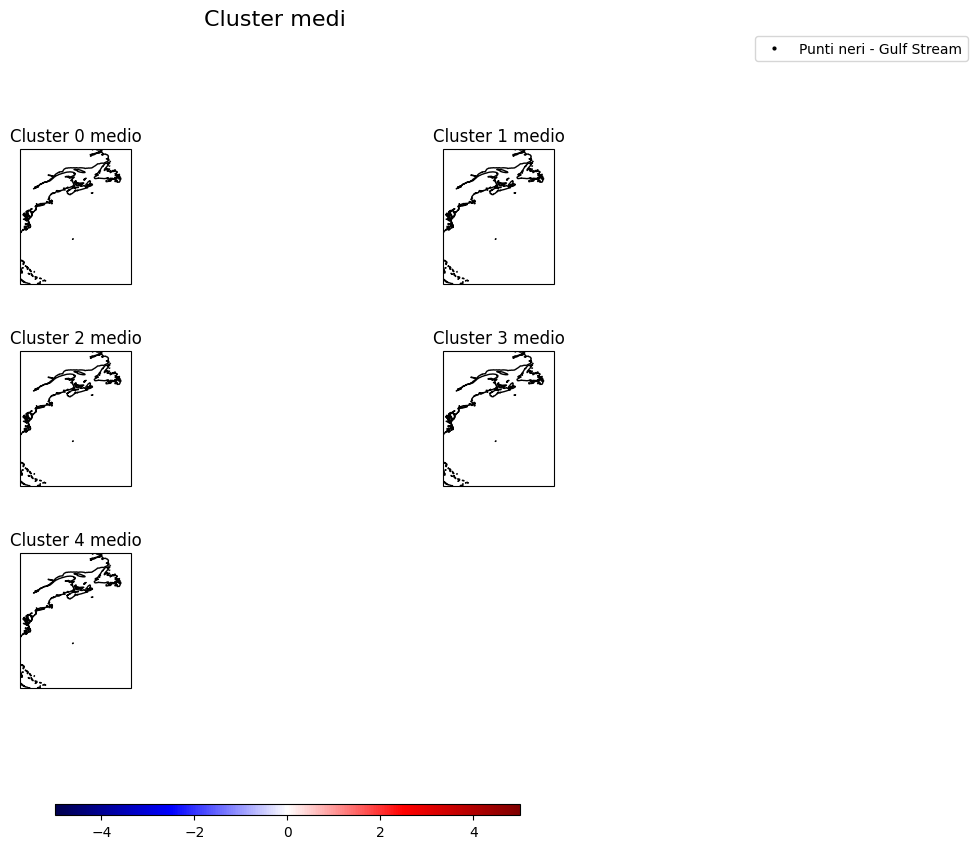

In [14]:
#Plot dei cluster medi
fig, ax = plt.subplots(nrows=int(n_clusters/2)+1, ncols=int(n_clusters/2), figsize=(10,10),subplot_kw={"projection": ccrs.PlateCarree()}) #trasformazione cartografica = lonxlat
fig.subplots_adjust(hspace=0.5, wspace=0.2)  # Aggiungo spazi verticali e orizzontali tra le subplots
for i in range(int(n_clusters/2)+1): # Ciclo sulle righe
    for j in range(int(n_clusters/2)): #Ciclo sulle colonne
        index = i*(int(n_clusters/2)) + j
        if index == n_clusters:
            break 
        plot_mod = ax[i,j].imshow(mean_cluster[index,::-1,:], vmin=-5, vmax=5,cmap='seismic')     
        coords = np.where(array_max[index,:,:] == 1) #array di valori di longitudini e latitudini in cui array_max = 1 (cioè indica la posizione in cui c'è il max))
        # Plot dei punti solo dove array_max è uguale a 1
        punti = ax[i,j].plot(lon[coords[1]], lat[coords[0]], marker='o', color='black', markersize=2, linestyle='None') 
        #ax[i,j].invert_yaxis()               
        ax[i,j].set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree()) 
        ax[i,j].coastlines() # Aggiungo le coste
        # Label degli assi
        ax[i,j].set_ylabel('latitude')
        ax[i,j].set_xlabel('longitude')
        ax[i,j].set_title(f'Cluster {index} medio') 


#Rimuovo i quadrati non utilizzati
for i in range(int(n_clusters/2)+1):
    for j in range(int(n_clusters/2)):
        index = i * int(n_clusters/2) + j
        if index >= n_clusters:
            ax[i,j].axis('off')

# Titolo
fig.colorbar(plot_mod, ax=ax, orientation='horizontal', shrink=0.6, aspect=40)
# Legenda per linee tratteggiate
fig.legend(['Punti neri - Gulf Stream'], loc='upper right', bbox_to_anchor=(1.2, 1))
fig.suptitle('Cluster medi', fontsize=16, y=1.02)

fig.show()